# Initializatoin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks/Deep\ Learning\ Course/HW03

/content/drive/.shortcut-targets-by-id/1uDq0M9_Wiov9oQCfOUMaHhMYYxVvHdyH/Deep Learning Course/HW03


## Imports

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [103]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print('category =', category, '- random name =', line)

Files already exist, skipping download and extraction.

category = Korean - random name = Suk

category = English - random name = Vallins

category = Polish - random name = Piatek

category = Vietnamese - random name = Nghiem

category = Greek - random name = Close

category = French - random name = Gage

category = Scottish - random name = Mckay

category = Korean - random name = Chang

category = Arabic - random name = Tahan

category = Greek - random name = Vassilopulos


In [192]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.output_act = nn.ReLU()
        self.hidden_act = nn.ReLU()

        #your_code
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size, bias = True)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias = False)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        hidden = self.hidden_act(self.h2h(hidden) + self.i2h(input))
        output = self.output_act(self.h2o(hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
rnn = RNN(n_letters, n_hidden, n_categories)

In [193]:
#your_code
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()

def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.shape[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    target = torch.zeros((dataset.n_categories))
    target[category_tensor] = 1
    output = output.view(-1)

    loss = criterion(output, target)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

And here you can train your model and see it's performance after each 5000 iterations

5000 5% 2.7425 Thuy is predicted as a "English" name, status = ✗ (Vietnamese)

10000 10% 2.4110 Archambault is predicted as a "Scottish" name, status = ✗ (French)

15000 15% 2.0225 Youj is predicted as a "Vietnamese" name, status = ✗ (Korean)

20000 20% 3.3591 Vicario is predicted as a "Russian" name, status = ✗ (Spanish)

25000 25% 1.6684 Pei is predicted as a "Vietnamese" name, status = ✗ (Chinese)

30000 30% 3.6939 Benedetti is predicted as a "German" name, status = ✗ (Italian)

35000 35% 3.0755 Bertolini is predicted as a "Spanish" name, status = ✗ (Italian)

40000 40% 0.8003 Crawford is predicted as a "Scottish" name, status = ✓

45000 45% 0.1111 Dritsas is predicted as a "Greek" name, status = ✓

50000 50% 0.5720 Ra is predicted as a "Korean" name, status = ✓

55000 55% 1.4695 Exon is predicted as a "English" name, status = ✓

60000 60% 0.1634 Henriques is predicted as a "Portuguese" name, status = ✓

65000 65% 0.0561 Arrigucci is predicted as a "Italian" name, status = ✓

70000 

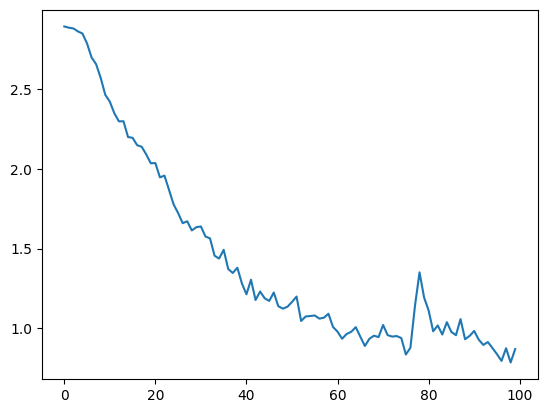

In [194]:
n_iters = 100000
print_every = 5000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s is predicted as a "%s" name, status = %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?

Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Answer: using GPU doesn't solve it completely, because we have sequential calculations and we should wait and go through all the steps, then the gradient will come back. we can not start future steps before calculating steps before them cause they need out hidden context.

Epoch [10/100], Loss: 1.3155

Epoch [20/100], Loss: 1.2138

Epoch [30/100], Loss: 1.1317

Epoch [40/100], Loss: 1.0595

Epoch [50/100], Loss: 0.9871

Epoch [60/100], Loss: 0.9074

Epoch [70/100], Loss: 0.8150

Epoch [80/100], Loss: 0.7044

Epoch [90/100], Loss: 0.5727

Epoch [100/100], Loss: 0.4279


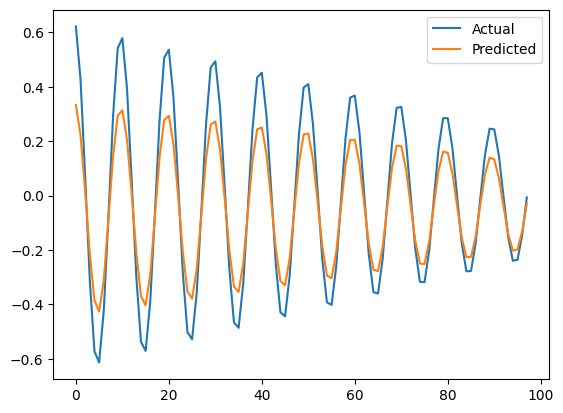

In [178]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = np.sin(np.linspace(0, 2*np.pi*num_periods, total_timesteps)) * decreasing_factor

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(temperature_data)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)

# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i:i+seq_length]
        seq_out = data[i+seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)

# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label='Actual')
plt.plot(test_predictions.numpy(), label='Predicted')
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [56]:
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor())

batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 11223150.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 328172.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:02<00:00, 647426.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 1877084.32it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [57]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## LSTM Cells

In [67]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()


        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        # self.xh2gates = nn.Linear(input_size+hidden_size, hidden_size * 4, bias=bias)
        
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, inp, hidden=None):

        # Inputs:
        #       input: (batch_size, input_size)
        #       hx: (batch_size, hidden_size)
        # Outputs:
        #       hy: (batch_size, hidden_size)
        #       cy: (batch_size, hidden_size)

        # if hx is None:
        #     hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
        #     hx = (hx, hx)

        hx, cx = hidden
        # ====================================
        # your code
        gates = self.xh(inp) + self.hh(hx)
        input_gate, forget_gate, output_gate, gate_gate = torch.chunk(gates, 4, dim=1)

        i_t = self.sigmoid(input_gate)
        f_t = self.sigmoid(forget_gate)
        g_t = self.tanh(gate_gate)
        o_t = self.sigmoid(output_gate)
        cy = cx * f_t + i_t*g_t
        hy = o_t* self.tanh(cy)

        return (hy, cy)

## LSTM Models

In [85]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        # Initialize hidden state with zeros
        hn = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device))
        cn = hn.clone()
        
        outs = []

        for seq in range(x.size(2)):
            # your code
            for layer in range(self.layer_dim):
                if layer == 0:
                    lstm_input = x[:, 0, seq]
                    # for i in range(lstm_input.shape[0]):
                    #     for j in range(lstm_input.shape[1]):
                    #         print(lstm_input[i, j])

                else:
                    lstm_input = hn[layer-1]
                hn[layer], cn[layer] = self.lstm(lstm_input, (hn[layer].clone(), cn[layer].clone()))

        #your code
        out = self.fc(hn[-1])
        return out

In [86]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Set device to GPU
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")   # Set device to CPU
    print("CUDA is not available. Using CPU.")


CUDA is available! Using GPU.


In [87]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)
# your code
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [88]:
# your code

# Train model and print Loss and Accuracy on Test Dataset after each 500 iterations

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # if (i+1) % 500 == 0:
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy))


Epoch [1/12], Step [469/469], Loss: 0.2222, Accuracy: 94.10%
Epoch [2/12], Step [469/469], Loss: 0.1360, Accuracy: 95.94%
Epoch [3/12], Step [469/469], Loss: 0.1219, Accuracy: 96.28%
Epoch [4/12], Step [469/469], Loss: 0.1815, Accuracy: 97.67%
Epoch [5/12], Step [469/469], Loss: 0.0195, Accuracy: 97.55%
Epoch [6/12], Step [469/469], Loss: 0.0449, Accuracy: 97.87%
Epoch [7/12], Step [469/469], Loss: 0.0516, Accuracy: 97.93%
Epoch [8/12], Step [469/469], Loss: 0.0410, Accuracy: 98.06%
Epoch [9/12], Step [469/469], Loss: 0.0469, Accuracy: 98.33%
Epoch [10/12], Step [469/469], Loss: 0.1086, Accuracy: 97.92%
Epoch [11/12], Step [469/469], Loss: 0.0736, Accuracy: 98.53%
Epoch [12/12], Step [469/469], Loss: 0.0406, Accuracy: 98.39%


# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.

In [27]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import Parameter
# from name_dataset import Dataset
import pandas as pd


df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [28]:
# import pandas as pd
# import re
# import nltk
# nltk.download('punkt', 'nltk_data')
# nltk.download('stopwords', 'nltk_data')
# nltk.download('wordnet', 'nltk_data')
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])



In [29]:
import re
import spacy

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    return text

df['clean_review'] = df['review'].apply(preprocess_text)
df['sentiment'] = df['sentiment'].map({'negative': 0.0, 'positive': 1.0})
df.head()


,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1.0,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1.0,A wonderful little production br br The filmin...
2,I thought this was a wonderful way to spend ti...,1.0,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0.0,Basically theres a family where a little boy J...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1.0,Petter Matteis Love in the Time of Money is a ...


In [30]:
X = df['clean_review'].values
y = df['sentiment'].values

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(X)
seqs = tk.texts_to_sequences(X)

In [32]:
from keras.preprocessing.sequence import pad_sequences
seqs = pad_sequences(seqs, maxlen=1024)

In [33]:
seqs = np.array(seqs)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(seqs, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [35]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(40000, 1024) (40000,)
(5000, 1024) (5000,)
(5000, 1024) (5000,)


In [36]:
vocab_size = len(tk.word_index) + 1  # Add 1 for the reserved index 0
vocab_size

177036

In [37]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype = int)
        self.y = torch.tensor(y, dtype = float)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
#         sample = {'input': self.X[idx], 'target': self.y[idx]}
        return self.X[idx], self.y[idx]


In [50]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
val_dataset = CustomDataset(X_val, y_val)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [46]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, vocab_size):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.embed = nn.Embedding(vocab_size, input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        x = self.embed(x)
        out, (hn, cn) = self.lstm(x)

        out = hn.permute(1, 0, 2)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return F.sigmoid(out).squeeze()


In [53]:
model = LSTMModel(128, 128, 2, 1, vocab_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

model.cuda()
num_epochs = 4

for epoch in range(num_epochs):
    # Training loop
    model.train()  # Set the model to train mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    cnt = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.float().cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()

        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    print('vvaaay')
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Forward pass
            inputs, targets = inputs.cuda(), targets.float().cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

vvaaay
Epoch [1/4], Train Loss: 0.5640, Train Acc: 0.6999, Val Loss: 0.3896, Val Acc: 0.8278
vvaaay
Epoch [2/4], Train Loss: 0.2707, Train Acc: 0.8897, Val Loss: 0.2639, Val Acc: 0.8910
vvaaay
Epoch [3/4], Train Loss: 0.1600, Train Acc: 0.9415, Val Loss: 0.2557, Val Acc: 0.8952
vvaaay
Epoch [4/4], Train Loss: 0.0865, Train Acc: 0.9716, Val Loss: 0.3168, Val Acc: 0.8916


In [55]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct_val = 0
total_val = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        # Forward pass
        inputs, targets = inputs.cuda(), targets.float().cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())
        val_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        correct_val += (predicted == targets).sum().item()
        total_val += targets.size(0)

val_loss /= len(val_loader.dataset)
val_accuracy = correct_val / total_val

print(f'test acc: {val_accuracy}')

test acc: 0.897
